In [1]:
# download ja_fonts
!sh /temp/work/setup_fonts.sh

In [2]:
import MeCab
import urllib
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', 10000)

In [3]:
class Cfg:
    seed = 42
    extract_feats = ['名詞', '形容詞']
    font_path = '../input/ipaexg00401/ipaexg.ttf'
    stopwords_lib = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'

In [4]:
data = pd.read_csv('../input/data.csv', engine='python')

## EDA

In [5]:
data.head(3)

,id,topic,status,label,text,pos&neg,pos,neg,neu,non
0,10025,10000.0,5.224077e+17,"[0, 0, 1, 1, 0]",エクスペリアのGPS南北が逆になるのはデフォだったのか。,0.0,0.0,1.0,1.0,0.0
1,10026,10000.0,5.224078e+17,"[0, 0, 1, 0, 0]",xperiaでスクフェス糞\n反応遅いんだよ糞が,0.0,0.0,1.0,0.0,0.0
2,10027,10000.0,5.224080e+17,"[0, 0, 1, 1, 0]",夏春都が持ってたエクスペリアも今使うには辛い,0.0,0.0,1.0,1.0,0.0


`id`: ツイートのid. unique.

`topic`: ジャンルのid. 主に家電の商品名で構成されている. not unique.

`status`: Twitterのstatus id. このidを元に、textを取得した.

`label`: multi label. 左から順に [positive&negative, positive, negative, neutral, none]

`text`: ツイート本文.

`pos&neg` ~ `non`: 個別のlabel

<br>

In [6]:
# 'topic'と'label'を文字列に置き換えていく
# 'id','status'は不要なので、dropする

topic_map = {
    10000.0: 'xperia',
    10001.0: 'aquos01',
    10002.0: 'aquos02',
    10020.0: 'cocorobo',
    10021.0: 'iphone',
    10022.0: 'panasonic',
    10024.0: 'copier',
    10025.0: 'roomba',
    10026.0: 'sharp',
}

label_map = {
    '[1, 0, 0, 0, 0]': 'positive&negative',
    '[0, 1, 0, 0, 0]': 'positive',
    '[0, 0, 1, 0, 0]': 'negative',
    '[0, 0, 0, 1, 0]': 'neutral',
    '[0, 0, 0, 0, 1]': 'none',
    '[1, 1, 0, 0, 0]': 'positive&negative+positive',
    '[1, 0, 1, 0, 0]': 'positive&negative+negative',
    '[1, 0, 0, 1, 0]': 'positive&negative+neutral',
    '[1, 0, 0, 0, 1]': 'positive&negative+none',
    '[0, 1, 1, 0, 0]': 'positive+negative',
    '[0, 1, 0, 1, 0]': 'positive+neutral',
    '[0, 1, 0, 0, 1]': 'positive+none',
    '[0, 1, 1, 1, 0]': 'positive+negative+neutral',
    '[0, 1, 1, 0, 1]': 'positive+negative+none',
    '[0, 1, 0, 1, 1]': 'positive+neutral+none',
    '[0, 0, 1, 1, 0]': 'negative+neutral',
    '[0, 0, 1, 0, 1]': 'negative+none',
    '[0, 0, 1, 1, 1]': 'negative+negative+none',
    '[0, 0, 0, 1, 1]': 'neutral+none',
    '[1, 1, 1, 1, 1]': 'positive&negative+positive+negative+netral+none'
}

data['topic'] = data['topic'].map(topic_map)
data['label'] = data['label'].map(label_map)
data = data.drop(['id','status'], axis=1)

In [7]:
data.head(1)

,topic,label,text,pos&neg,pos,neg,neu,non
0,xperia,negative+neutral,エクスペリアのGPS南北が逆になるのはデフォだったのか。,0.0,0.0,1.0,1.0,0.0


In [8]:
print(f'データセットの総数: {len(data)}\n')
print(f'データの欠損数:\n{data.isnull().sum()}\n')
print(f'データの重複(カラム全体): {data.duplicated().sum()}\n')
print(f'データの重複(label+text): {data.duplicated(subset=["label","text"]).sum()}\n')
print(f'データの重複(topic+text): {data.duplicated(subset=["topic","text"]).sum()}\n')

データセットの総数: 299250

データの欠損数:
topic      56
label      56
text       28
pos&neg    56
pos        84
neg        84
neu        84
non        84
dtype: int64

データの重複(カラム全体): 51

データの重複(label+text): 74

データの重複(topic+text): 53



In [9]:
# 欠損値とデータの重複(label+text)をdrop
data = data.dropna(how='any')
data = data.drop_duplicates(subset=['label','text'])
data = data.reset_index(drop=True)

In [10]:
## visualization function

def value_counts_plot(df, column, fontsize=15, figsize=(15,10), title=None):
    label_counts = df[column].value_counts()
    
    plt.figure(figsize=figsize)
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    bar_colors = cm.rainbow(np.linspace(0,1,len(df[column].unique())))
    
    plt.bar(label_counts.index.values,
            label_counts.values,
            color=bar_colors,
            linewidth=0,
            alpha=0.6)
    plt.tick_params(labelsize=fontsize)
    plt.xticks(rotation=-45, ha='left')
    plt.xlabel(column, fontsize=fontsize)
    plt.ylabel(f'{column} value counts', fontsize=fontsize)
    if title is not None:
        plt.title(title, fontsize=fontsize)
    plt.show()
    
    
def categorical_value_counts_plot(df, columns, fontsize=15, figsize=(15,10), title=None):
    label_counts = [int(data[column].value_counts().loc[1.0]) for column in columns]
    
    plt.figure(figsize=figsize)
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    bar_colors = cm.rainbow(np.linspace(0,1,len(columns)))
    
    plt.bar(columns,
            label_counts,
            color=bar_colors,
            linewidth=0,
            alpha=0.6)
    plt.tick_params(labelsize=fontsize)
    plt.xticks(rotation=-45, ha='left')
    plt.xlabel('labels', fontsize=fontsize)
    plt.ylabel(f'labels value counts', fontsize=fontsize)
    if title is not None:
        plt.title(title, fontsize=fontsize)
    plt.show()
    
    
def text_length_plot(df, text_column, fontsize=15, alpha=1.0, title=None):
    df['text_len'] = df[text_column].apply(lambda x: len(x))
    
    plt.figure(figsize=(15,10))
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    df['text_len'].plot(
        bins=50, 
        kind='hist', 
        color='blue',
        alpha=alpha
    )
    df.drop('text_len', axis=1, inplace=True)
    plt.tick_params(labelsize=fontsize)
    plt.legend()
    plt.xlabel('text length', fontsize=fontsize)
    plt.ylabel('frequency', fontsize=fontsize)
    if title is not None:
        plt.title(title, fontsize=fontsize)
    plt.show()
    
    
class CustomMeCabTagger(MeCab.Tagger):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
    def apply_stopwords(self, text):
        libfile = urllib.request.urlopen(self.config.stopwords_lib)
        lib_stopwords = [line.decode('utf-8').strip() for line in libfile]
        lib_stopwords = [stopwords for stopwords in lib_stopwords if not stopwords == u'']
        lib_stopwords = list(set(lib_stopwords))        
        text = ' '.join(
            [
                word \
                for word in text.split(' ') \
                if word not in lib_stopwords \
                if not word.isdigit() \
                if len(word) != 1
            ]
        )
        return text
        
    def parse_to_text(self, series):
        results = []
        texts = ' '.join(series.tolist())
        for sentence in texts.split('。'):
            parsed = self.parse(sentence)
            for line in parsed.split('\n'):
                try:
                    text, feature = line.split('\t')
                except ValueError:
                    pass
                feature = [None if f == '*' else f for f in feature.split(',')][0]
                if isinstance(self.config.extract_feats, list):
                    if feature in self.config.extract_feats:
                        results.append(text)
                else:
                    results.append(text)
        parsed_text = ' '.join(results)
        return self.apply_stopwords(parsed_text)
    
    
def word_cloud(series, title, config):
    japanize_matplotlib.japanize()
    wc = WordCloud(width=900, height=600, font_path=config.font_path) 
    tagger = CustomMeCabTagger(config)
    wc.generate(tagger.parse_to_text(series))
    plt.figure(figsize=(25,17))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontdict={'fontsize': 20})

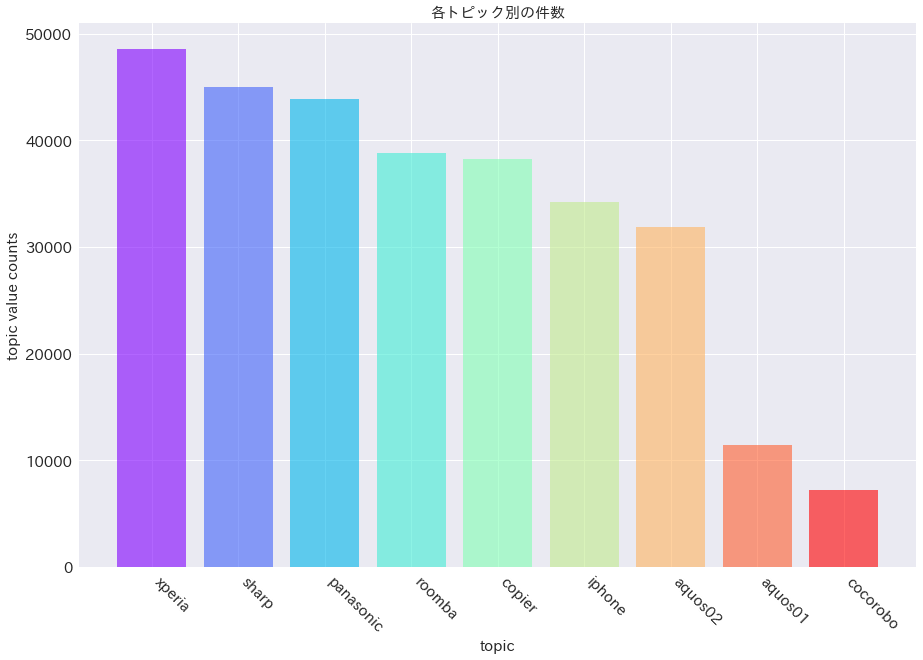

In [11]:
value_counts_plot(data, column='topic', title='各トピック別の件数')

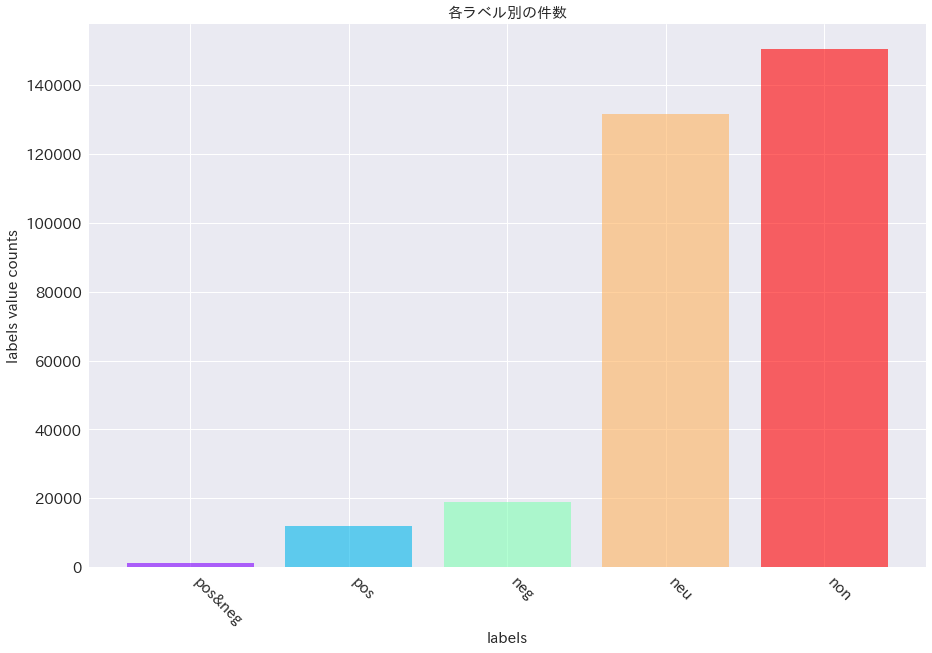

In [12]:
categorical_value_counts_plot(
    data, 
    columns=['pos&neg','pos','neg','neu','non'], 
    title='各ラベル別の件数'
)

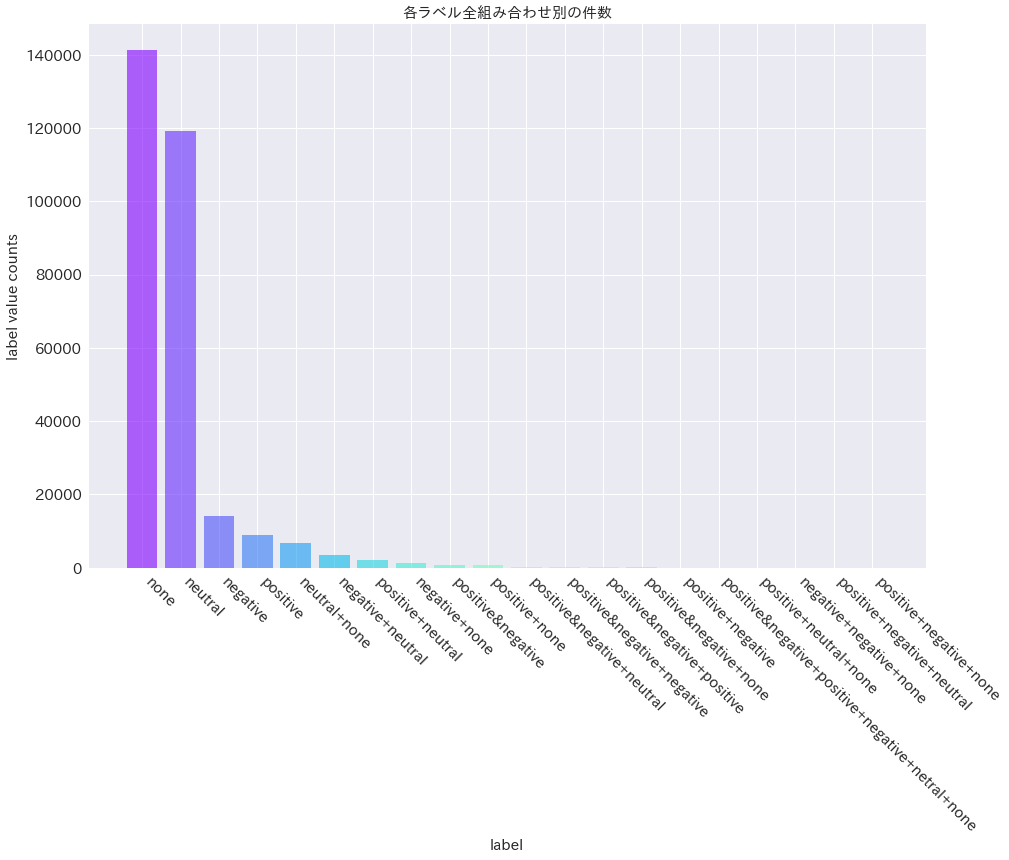

In [13]:
value_counts_plot(
    data, 
    column='label', 
    title='各ラベル全組み合わせ別の件数'
)

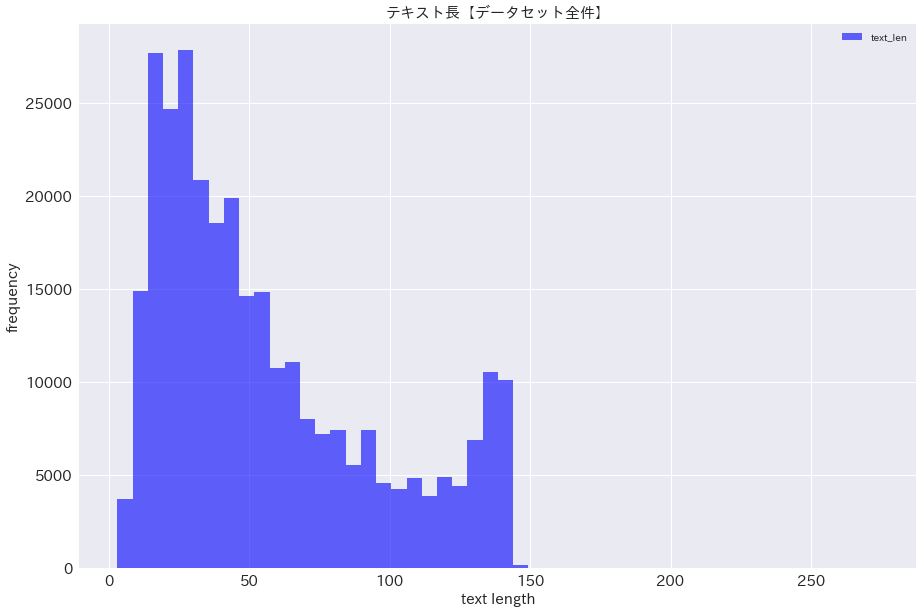

In [14]:
text_length_plot(
    data, 
    text_column='text', 
    alpha=0.6, 
    title='テキスト長【データセット全件】'
)

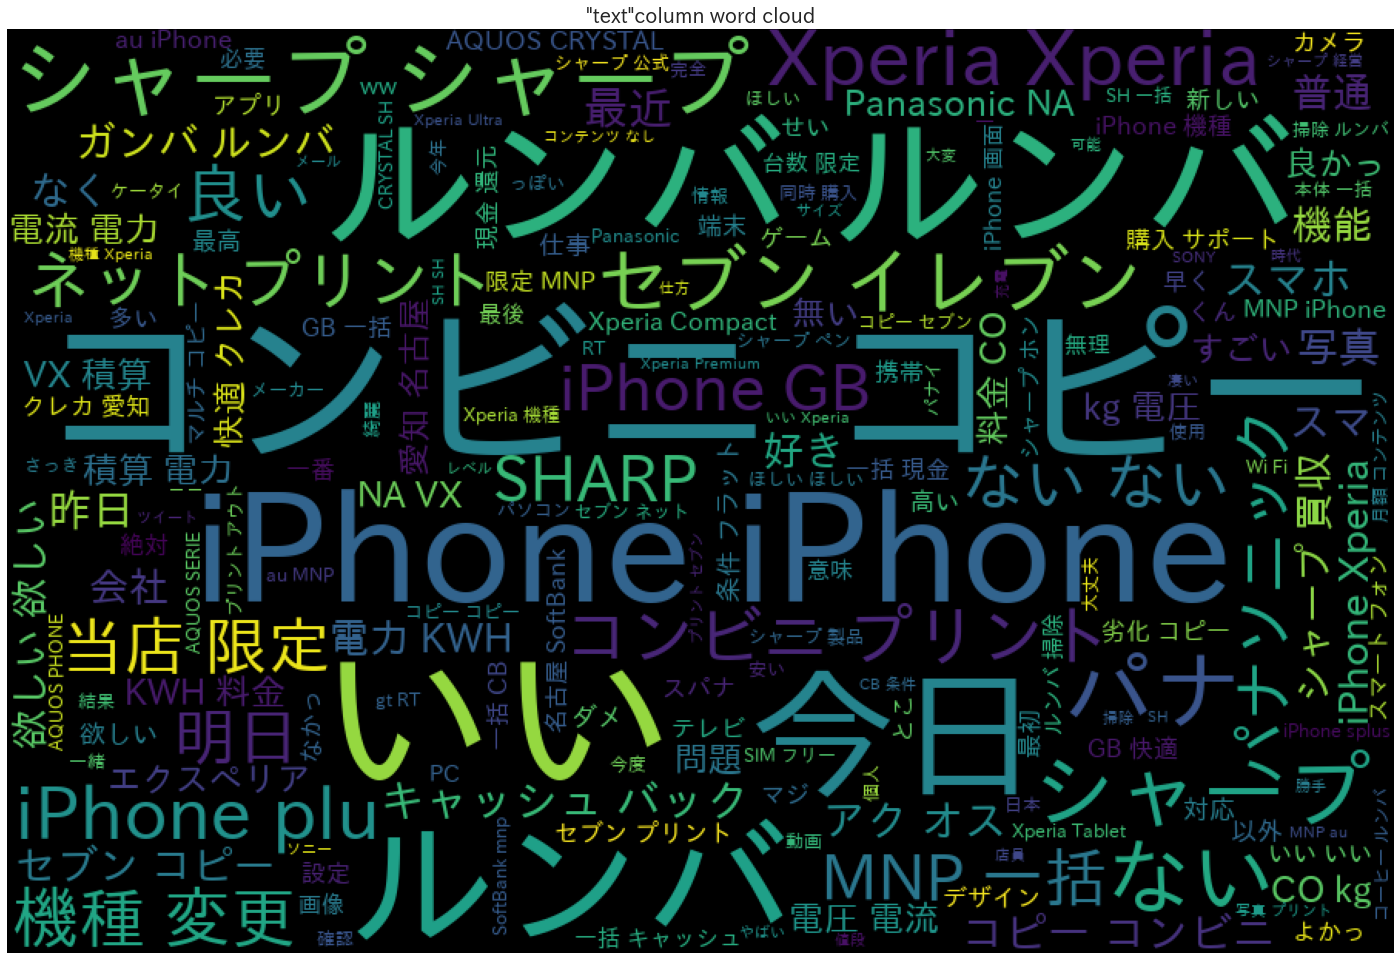

In [15]:
word_cloud(data['text'], '"text"column word cloud', Cfg)

## Preprocess

In [16]:
def text_normalize(text):
    text = text.strip()
    text = unicodedata.normalize('NFKC', text)
    return text

def text_preprocess(text):
    text = text.replace('\n', '')
    return text

def apply_preprocess(df):
    new_df = df.copy()
    new_df['pos&neg'] = new_df['pos&neg'].map(np.float32)
    new_df['pos'] = new_df['pos'].map(np.float32)
    new_df['neg'] = new_df['neg'].map(np.float32)
    new_df['neu'] = new_df['neu'].map(np.float32)
    new_df['non'] = new_df['non'].map(np.float32)
    new_df['text'] = new_df['text'].map(text_normalize)
    new_df['text'] = new_df['text'].map(text_preprocess)
    return new_df

preprocessed_data = apply_preprocess(data)
preprocessed_data = preprocessed_data.drop(['topic', 'label'], axis=1)

In [17]:
preprocessed_data.sample(30)

,text,pos&neg,pos,neg,neu,non
224627,コンビニプリント...!!?,0.0,0.0,0.0,1.0,0.0
78261,先日、ずっと悩んでたレンズを購入!使ってたタムロンは質感が柔らかかったので、買うとしたら結構シャープに写るシグマにしたいなって考えましたので、いい子を買えて良かったです!,0.0,0.0,0.0,0.0,1.0
165391,ソーラー、ウインター、コマーシャル→ウェザーリポートモンスター、レッカー、トラベラー→タフガイマンターン、ジャッキー、スパナー→グランプリ,0.0,0.0,0.0,0.0,1.0
297972,え?iPhone5sだけど?iPhone6のカバーかわいいから??買いますけど???,0.0,0.0,0.0,1.0,0.0
277578,iPad Air2ならバックグラウンドで何が起きてもデレステに影響しないんだけどなあ。やっぱりiPhone6sならこんなことないのだろうか...,0.0,0.0,0.0,1.0,0.0
272926,ルンバ長い。ルンバうるさい。今日29日やで?1日多いんやで?なのになんでいつもより長い時間働いているんだ君は,0.0,0.0,1.0,0.0,0.0
190093,今日のうちに機材シャープに運んでおこうと思ったのに今行動開始ですわあきらめ,0.0,0.0,0.0,0.0,1.0
122117,コンビニコピー機でバサラブロマイドやってるらしいが、果たして最北県の超ド田舎のコンビニコピー機が対応してるかどうかが一番の疑問である。,0.0,0.0,0.0,1.0,0.0
150812,シャープさん、もうヤケクソになってるな,0.0,0.0,0.0,1.0,0.0
44752,XPERIA Z2じゃカイロ機能ないから寒いなぁ,0.0,0.0,0.0,1.0,0.0


In [18]:
preprocessed_data.to_csv('../input/preprocessed_data.csv', index=False)
preprocessed_data = pd.read_csv('../input/preprocessed_data.csv').dropna(how='any').reset_index(drop=True)
preprocessed_data.to_csv('../input/preprocessed_data.csv', index=False)